In [2]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 84.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.3 MB/s eta 0:00:00


Files already downloaded and verified


/tmp/ipykernel_30/980005887.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/model_epoch_50/pytorch/default/1/model_epoch

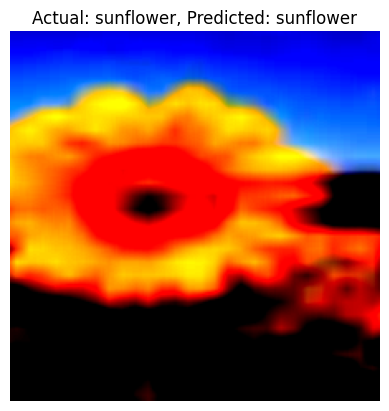

In [12]:
import torch
import timm
import matplotlib.pyplot as plt
from timm.data import create_dataset, create_loader
from timm.data.transforms_factory import create_transform
from torch.utils.data import DataLoader


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define input size and transformations
input_size = 224  # Model's expected input size
transform = create_transform(input_size=224, is_training=False)  # Create transformation

# Load CIFAR-100 dataset

test_dataset = create_dataset('torch/cifar100', root='./data', download=True, split='validation')
transform_val = create_transform(input_size=224, is_training=False)
test_dataset.transform = transform_val

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)


# Load the model and move to device
model = timm.create_model('efficientvit_m5.r224_in1k', pretrained=False, num_classes=100)
model.load_state_dict(torch.load("/kaggle/input/model_epoch_50/pytorch/default/1/model_epoch_50.pth"))  # Load trained model weights
model.to(device)
model.eval()  # Set model to evaluation mode

# Get a single sample (image and label) from the CIFAR-100 dataset
actual_input, actual_label = next(iter(data_loader))
actual_input = actual_input.to(device)  # Move image to device

# Get the prediction from the model
with torch.no_grad():
    output = model(actual_input)  # Forward pass
    _, predicted_label = torch.max(output, 1)  # Get the index of the max logit
    predicted_label = predicted_label.item()  # Extract label as integer

# Display the image with actual and predicted labels
class_names = dataset.class_to_idx
class_names = {v: k for k, v in class_names.items()}  # Reverse to map index -> class name

plt.imshow(actual_input.cpu().squeeze().permute(1, 2, 0).numpy())  # Display the image in (H, W, C) format
plt.title(f"Actual: {class_names[actual_label.item()]}, Predicted: {class_names[predicted_label]}")
plt.axis('off')
plt.show()


In [15]:
import torch
import time
import timm
import onnx
import onnxruntime as ort
import torch.cuda.amp as amp
from torch.quantization import quantize_dynamic
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_dataset = create_dataset('torch/cifar100', root='./data', download=True, split='validation')
transform_val = create_transform(input_size=224, is_training=False)
test_dataset.transform = transform_val
data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)
test_input, actual_label = next(iter(data_loader))

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model architecture and load saved weights
model = timm.create_model('efficientvit_m5.r224_in1k', pretrained=False, num_classes=100)
model.load_state_dict(torch.load("/kaggle/input/model_epoch_50/pytorch/default/1/model_epoch_50.pth"))  # Load the model saved after 50 epochs
model.to(device)
model.eval()  # Set the model to evaluation mode

# Method to measure inference time
def measure_inference_time(model, input_tensor, num_runs=100):
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            model(input_tensor)
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / num_runs
    print(f"Average Inference Time: {avg_inference_time:.4f} seconds")
    return avg_inference_time

# 1. TorchScript Optimization
print("Optimizing with TorchScript...")
scripted_model = torch.jit.script(model)
torchscript_time = measure_inference_time(scripted_model, test_input.to(device))

# 2. Dynamic Quantization (only for CPU)
if device.type == 'cpu':
    print("Optimizing with Dynamic Quantization...")
    quantized_model = quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)  # Quantize Linear layers
    quantized_time = measure_inference_time(quantized_model, test_input)
else:
    quantized_time = None

# 3. ONNX Export and ONNX Runtime Inference
print("Optimizing with ONNX Runtime...")
torch.onnx.export(model, test_input.to(device), "model.onnx", input_names=['input'], output_names=['output'], opset_version=11)
ort_session = ort.InferenceSession("model.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# Measure ONNX inference time
start_time = time.time()
for _ in range(100):  # Run 100 inferences
    ort_session.run(None, {"input": to_numpy(test_input)})
end_time = time.time()
onnx_time = (end_time - start_time) / 100
print(f"Average ONNX Inference Time: {onnx_time:.4f} seconds")

# 4. Mixed Precision (only on CUDA)
if device.type == "cuda":
    print("Optimizing with Mixed Precision (CUDA)...")
    with amp.autocast():
        mixed_precision_time = measure_inference_time(model, test_input.to(device))
else:
    mixed_precision_time = None

# Summarize Results
print("\n--- Inference Time Summary ---")
print(f"TorchScript Inference Time: {torchscript_time:.4f} seconds")
if quantized_time is not None:
    print(f"Quantized Inference Time: {quantized_time:.4f} seconds")
print(f"ONNX Inference Time: {onnx_time:.4f} seconds")
if mixed_precision_time is not None:
    print(f"Mixed Precision Inference Time: {mixed_precision_time:.4f} seconds")


Files already downloaded and verified


/tmp/ipykernel_30/2865227827.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/model_epoch_50/pytorch/default/1/model_epoc

Optimizing with TorchScript...
Average Inference Time: 0.0123 seconds
Optimizing with ONNX Runtime...


/opt/conda/lib/python3.10/site-packages/torch/__init__.py:1777: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message
/opt/conda/lib/python3.10/site-packages/torch/onnx/_internal/jit_utils.py:314: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /usr/local/src/pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/opt/conda/lib/python3.10/site-packages/torch/onnx/utils.py:739: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /usr/local/src/pytorch/torch/csrc/j

Average ONNX Inference Time: 0.0097 seconds
Optimizing with Mixed Precision (CUDA)...


/tmp/ipykernel_30/2865227827.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Average Inference Time: 0.0299 seconds

--- Inference Time Summary ---
TorchScript Inference Time: 0.0123 seconds
ONNX Inference Time: 0.0097 seconds
Mixed Precision Inference Time: 0.0299 seconds
